## Data Cleaning & Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
#reads the abridged csv into a pandas dataframe
wvs = pd.read_csv('~/Data/WVS_abridged.csv')

In [4]:
#cuts out unnecessary columns
wvs = wvs.iloc[:,1:-6]

In [5]:
wvs.head()

,S020,S025,COW_ALPHA,Y001,Y002,Y003,Y010,Y011,Y012,Y013,...,Y021C,Y022A,Y022B,Y022C,Y023A,Y023B,Y023C,Y024A,Y024B,Y024C
0,2018,202018,AND,0.0,1.0,0.0,0.287062,0.38258,0.666667,0.0,...,0.0,0.75,0.66,0.66,0.333333,0.111111,0.444444,0.00,0.0,0.000
1,2018,202018,AND,2.0,3.0,1.0,0.467525,0.22000,1.000000,0.0,...,0.0,0.75,0.66,0.66,0.888889,0.888889,0.888889,1.00,0.0,0.500
2,2018,202018,AND,4.0,2.0,-2.0,0.425304,0.44000,0.886667,0.0,...,1.0,0.75,0.66,0.66,1.000000,0.444444,0.555556,0.33,0.5,0.415
3,2018,202018,AND,2.0,2.0,0.0,0.556170,0.57458,1.000000,0.0,...,0.0,0.75,1.00,1.00,0.555556,0.333333,0.888889,0.33,0.5,0.415
4,2018,202018,AND,1.0,1.0,-1.0,0.458949,0.57458,0.886667,0.0,...,1.0,0.75,0.66,0.66,0.777778,0.444444,0.666667,0.00,0.5,0.250


In [6]:
#reads in a text file with current column names and descriptions
with open ('columns.txt', 'r') as col_names:
    strings=col_names.read()

In [7]:
col_names = ['S020', 'S025', 'COW_ALPHA']
#pulls current column names from text file
for string in re.findall('Y[0-9][0-9][0-9]',strings):
    if string not in col_names:
        col_names.append(string)
    elif string + 'A' not in col_names:
        col_names.append(string + 'A')
    elif string + 'B' not in col_names:
        col_names.append(string + 'B')
    elif string + 'C' not in col_names:
        col_names.append(string + 'C')

In [8]:
new_names = ['YEAR', 'YEAR_COUNTRY', 'COUNTRY', 'POSTMAT_IND12', 'POSTMAT_IND4', 'AUTONOMY_IND']
#pulls descriptors to be used as new column names
for string in re.findall('[A-Z][A-Z][A-Z]*',strings):
    new_names.append(string)

In [9]:
#creates a mapper of old column names to new ones
col_dict = {col_names[i]:new_names[i] for i in range(0,len(col_names))}

In [10]:
#renames the columns according to the mapper
wvs.rename(columns = col_dict, inplace=True)
#fixes an error with the 3-letter codes
wvs.loc[(wvs['YEAR_COUNTRY']==8071998)|(wvs['YEAR_COUNTRY']==8072001), 'COUNTRY'] = 'MKD'

In [12]:
#reads in the imports and exports file
trade = pd.read_csv('~/Data/Exports & Imports by NAICS Commodities.csv', skiprows=3)

In [13]:
#gets rid of extra columns
trade = trade.iloc[:,:-1]

In [14]:
#creates a list of regexes for each 3-letter country code
country_regexes = []
for country in wvs['COUNTRY'].unique():
    letters = []
    for letter in country:
        letters.append(letter)
    regex_format = '^' + letters[0] + '.*' + letters[1] + '.*' + letters[2]
    country_regexes.append(regex_format)

In [15]:
#applies the regexes to the Country column in trade df to make a new column matching 3-letter codes
def make_codes(row):
    codes = []
    for regex,country in zip(country_regexes, wvs['COUNTRY'].unique()):
        if re.search(regex, row['Country'], flags=re.IGNORECASE):
            codes.append(country)
    return codes

In [16]:
trade['COUNTRY'] = trade.apply(make_codes,axis=1)
#cleans up entries in new COUNTRY column
trade['COUNTRY'] = trade.apply(lambda x: x['COUNTRY'][0] if len(x['COUNTRY'])>=1 else x['COUNTRY'], axis=1)

In [17]:
#some hand-cleaning
trade.loc[trade['Country']=='Burma','COUNTRY'] = 'MYA'
trade.loc[trade['Country']=='El Salvador','COUNTRY'] = 'SAL'
trade.loc[trade['Country']=='Korea, South','COUNTRY'] = 'ROK'
trade.loc[trade['Country']=='Bosnia and Herzegovina','COUNTRY'] = 'BOS'
trade.loc[trade['Country']=='Bulgaria','COUNTRY'] = 'BUL'
trade.loc[trade['Country']=='Burkina Faso','COUNTRY'] = 'BFO'
trade.loc[trade['Country']=='Czech Republic','COUNTRY'] = 'CZR'
trade.loc[trade['Country']=='Indonesia','COUNTRY'] = 'INS'
trade.loc[trade['Country']=='Macedonia','COUNTRY'] = 'MKD'
trade.loc[trade['Country']=='Malaysia','COUNTRY'] = 'MAL'
trade.loc[trade['Country']=='Mali','COUNTRY'] = 'MLI'
trade.loc[trade['Country']=='Nicaragua','COUNTRY'] = 'NIC'
trade.loc[trade['Country']=='Saudi Arabia','COUNTRY'] = 'SAU'
trade.loc[trade['Country']=='Serbia and Montenegro (Aug 2003 - Dec 2006)','COUNTRY'] = 'SRB'
trade.loc[trade['Country']=='Slovenia','COUNTRY'] = 'SLV'
trade.loc[trade['Country']=='Slovakia','COUNTRY'] = 'SLO'
trade.loc[trade['Country']=='Spain','COUNTRY'] = 'SPN'
trade.loc[trade['Country']=='Switzerland','COUNTRY'] = 'SWZ'
trade.loc[trade['Country']=='Uruguay','COUNTRY'] = 'URU'
trade.loc[trade['Country']=='Uzbekistan','COUNTRY'] = 'UZB'
trade.loc[trade['Country']=='Vietnam','COUNTRY'] = 'DRV'
trade.loc[trade['Country']=='Gaza Strip Administered by Israel','COUNTRY'] = 'PSE'

In [18]:
#creates a YEAR column from cleaned up Time column
trade['YEAR'] = trade['Time'].str.replace(' through July','').astype(int)

In [19]:
#creates a list of numeric columns in trade df
numeric_cols = ['Total Exports Value ($US)','Balance ($US)','Customs Import Value (Gen) ($US)']

In [20]:
#cleans up numeric columns
for col in numeric_cols:
    trade[col] = trade[col].str.replace(',','').astype(float)

In [21]:
#drops the now unnecessary and messier Time and Country columns
trade = trade.drop(columns=['Time','Country'])

In [22]:
trade

,Total Exports Value ($US),Balance ($US),Customs Import Value (Gen) ($US),COUNTRY,YEAR
0,4.347971e+06,425772.0,3922199.0,ALB,2002
1,1.846407e+08,184555995.0,84701.0,ALG,2002
2,1.212885e+07,-127761270.0,139890122.0,ARG,2002
3,2.197494e+06,2197494.0,NaN,ARM,2002
4,7.470171e+07,-7503573.0,82205284.0,AUL,2002
...,...,...,...,...,...
1895,1.150643e+08,113735159.0,1329142.0,VEN,2020
1896,1.300591e+09,521055285.0,779536125.0,DRV,2020
1897,1.246832e+08,123235454.0,1447777.0,YEM,2020
1898,8.837500e+04,-1155842.0,1244217.0,ZAM,2020


In [23]:
#adds a year to our column in wvs so that when we merge with trade, we don't have future leakage
wvs['YEAR'] = wvs['YEAR'] + 1

In [24]:
#merges the two datasets using their COUNTRY and YEAR columns
both = wvs.merge(trade, on=['COUNTRY','YEAR'], how='left')

In [25]:
both

,YEAR,YEAR_COUNTRY,COUNTRY,POSTMAT_IND12,POSTMAT_IND4,AUTONOMY_IND,SACSECVAL,DEFIANCE,DISBELIEF,RELATIVISM,...,CWOMEDU,AHOMOLIB,BABORTLIB,CDIVORLIB,AVOICE,BVOICE,CVOI,Total Exports Value ($US),Balance ($US),Customs Import Value (Gen) ($US)
0,2019,202018,AND,0.0,1.0,0.0,0.287062,0.382580,0.666667,0.000000,...,0.66,0.333333,0.111111,0.444444,0.00,0.0,0.000,NaN,NaN,NaN
1,2019,202018,AND,2.0,3.0,1.0,0.467525,0.220000,1.000000,0.000000,...,0.66,0.888889,0.888889,0.888889,1.00,0.0,0.500,NaN,NaN,NaN
2,2019,202018,AND,4.0,2.0,-2.0,0.425304,0.440000,0.886667,0.000000,...,0.66,1.000000,0.444444,0.555556,0.33,0.5,0.415,NaN,NaN,NaN
3,2019,202018,AND,2.0,2.0,0.0,0.556170,0.574580,1.000000,0.000000,...,1.00,0.555556,0.333333,0.888889,0.33,0.5,0.415,NaN,NaN,NaN
4,2019,202018,AND,1.0,1.0,-1.0,0.458949,0.574580,0.886667,0.000000,...,0.66,0.777778,0.444444,0.666667,0.00,0.5,0.250,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423943,2013,7162012,ZIM,3.0,2.0,-1.0,0.138056,0.166667,0.055556,0.000000,...,0.66,0.000000,0.000000,0.000000,0.66,1.0,0.830,134980.0,-2361913.0,2496893.0
423944,2013,7162012,ZIM,4.0,2.0,0.0,0.207222,0.333333,0.055556,0.000000,...,1.00,0.000000,0.000000,0.000000,0.66,0.5,0.580,134980.0,-2361913.0,2496893.0
423945,2013,7162012,ZIM,4.0,2.0,1.0,0.110000,0.000000,0.000000,0.000000,...,0.66,0.000000,0.000000,0.000000,0.33,1.0,0.665,134980.0,-2361913.0,2496893.0
423946,2013,7162012,ZIM,3.0,1.0,-1.0,0.220833,0.333333,0.000000,0.000000,...,1.00,0.000000,0.000000,0.444444,0.00,1.0,0.500,134980.0,-2361913.0,2496893.0


In [26]:
#list of all the categorical columns
cat_cols = ['POSTMAT_IND12','POSTMAT_IND4', 'AUTONOMY_IND','AAUTHORITY', 'BNATIONALISM', 
            'CDEVOUT', 'ARELIGIMP', 'BRELIGBEL','CRELIGPRAC', 'ANORM', 'BNORM', 'CNORM', 
            'ATRUSTARMY', 'BTRUSTPOLICE','CTRUSTCOURTS', 'AINDEP', 'BIMAGIN', 'CNONOBED', 
            'AWOMJOB', 'BWOMPOL','CWOMEDU','AVOICE', 'BVOICE','CVOI']

In [27]:
#assigns the object type to the categorical columns
both[cat_cols] = both[cat_cols].astype('object')

In [28]:
#dummy-codes categorical and nominal variables
both = pd.get_dummies(both, drop_first=True)

In [29]:
print('Columns w/ High Homogeneity:')
for col in both:
    if (both[col].value_counts(normalize=True)*100).sort_values(ascending=False).iloc[0] > 99:
        print(col)

Columns w/ High Homogeneity:
COUNTRY_ALG
COUNTRY_AND
COUNTRY_ARM
COUNTRY_AZE
COUNTRY_BFO
COUNTRY_BNG
COUNTRY_BOL
COUNTRY_BOS
COUNTRY_BUL
COUNTRY_CRO
COUNTRY_CYP
COUNTRY_CZR
COUNTRY_DOM
COUNTRY_DRV
COUNTRY_ECU
COUNTRY_EST
COUNTRY_ETH
COUNTRY_FIN
COUNTRY_FRN
COUNTRY_GHA
COUNTRY_GRC
COUNTRY_GUA
COUNTRY_HAI
COUNTRY_HUN
COUNTRY_ISR
COUNTRY_ITA
COUNTRY_KUW
COUNTRY_KYR
COUNTRY_KZK
COUNTRY_LAT
COUNTRY_LEB
COUNTRY_LIB
COUNTRY_LIT
COUNTRY_MAC
COUNTRY_MAL
COUNTRY_MKD
COUNTRY_MLD
COUNTRY_MLI
COUNTRY_MNG
COUNTRY_MOR
COUNTRY_MYA
COUNTRY_NEW
COUNTRY_NIC
COUNTRY_NOR
COUNTRY_NTH
COUNTRY_POL
COUNTRY_PRI
COUNTRY_PSE
COUNTRY_QAT
COUNTRY_RWA
COUNTRY_SAL
COUNTRY_SAU
COUNTRY_SIN
COUNTRY_SLO
COUNTRY_SLV
COUNTRY_SWZ
COUNTRY_TAJ
COUNTRY_TAZ
COUNTRY_THI
COUNTRY_TRI
COUNTRY_TUN
COUNTRY_UGA
COUNTRY_UKG
COUNTRY_URU
COUNTRY_UZB
COUNTRY_VEN
COUNTRY_YEM
COUNTRY_ZAM
COUNTRY_ZIM
CRELIGPRAC_0.666666666666667


Clearly the country isn't going to be very useful to us, given that the vast majority of countries contribute only 1% to the data set or less. 

In [30]:
#lists the % of null values for each column in the data set
(both.isnull().sum()/423948*100).sort_values()

YEAR                                 0.000000
POSTMAT_IND12_3.0                    0.000000
POSTMAT_IND12_4.0                    0.000000
POSTMAT_IND12_5.0                    0.000000
POSTMAT_IND4_2.0                     0.000000
                                      ...    
AHOMOLIB                            10.667110
EQUALITY                            13.467454
Balance ($US)                       38.090992
Total Exports Value ($US)           39.043232
Customs Import Value (Gen) ($US)    40.927661
Length: 194, dtype: float64

Since Total Exports Value will be our target column, we can go ahead and drop any rows that are empty for this column.

In [31]:
#drops columns with missing values for Exports
both = both.dropna(axis=0, subset=['Total Exports Value ($US)'])

In [32]:
#re-lists the % missing from each column
(both.isnull().sum()/len(both)*100).sort_values()

YEAR                  0.000000
POSTMAT_IND12_3.0     0.000000
POSTMAT_IND12_4.0     0.000000
POSTMAT_IND12_5.0     0.000000
POSTMAT_IND4_2.0      0.000000
                       ...    
RELATIVISM            5.892232
CHOICE                6.457580
BABORTLIB             6.920383
SCEPTICISM            7.526362
AHOMOLIB             12.304537
Length: 194, dtype: float64

In [33]:
#imputes null values with the column median
for col in both:
    both[col] = both[col].fillna(both[col].median())

In [34]:
#applies min-max scaling to our columns
for col in both:
    both[col] = (both[col] - both[col].min()) / (both[col].max() - both[col].min())

## Feature Selection

In [35]:
#returns any highly correlated columns so we can determine if we have overlapping info
for col in both:
    for col2 in both:
        if col != col2:
            if abs(both[col].corr(both[col2])) >= 0.75:
                print(col +': '+ col2 + ", r = " + str(both[col].corr(both[col2])))

DISBELIEF: BRELIGBEL_1.0, r = 0.8028431352626075
RELATIVISM: ANORM_1.0, r = 0.798827805565915
RELATIVISM: BNORM_1.0, r = 0.8451701660354958
RELATIVISM: CNORM_1.0, r = 0.8143553259240756
CHOICE: AHOMOLIB, r = 0.8040143168285806
CHOICE: BABORTLIB, r = 0.8330386152679105
CHOICE: CDIVORLIB, r = 0.8382752316615014
AHOMOLIB: CHOICE, r = 0.8040143168285806
BABORTLIB: CHOICE, r = 0.8330386152679105
CDIVORLIB: CHOICE, r = 0.8382752316615013
Total Exports Value ($US): Balance ($US), r = 0.8127806694299458
Balance ($US): Total Exports Value ($US), r = 0.8127806694299458
Balance ($US): COUNTRY_CHN, r = 0.7757478089471198
Customs Import Value (Gen) ($US): COUNTRY_MEX, r = 0.8595020878539458
COUNTRY_CHN: Balance ($US), r = 0.7757478089471198
COUNTRY_MEX: Customs Import Value (Gen) ($US), r = 0.8595020878539458
POSTMAT_IND4_3.0: AVOICE_1.0, r = 0.9999999999999998
BRELIGBEL_1.0: DISBELIEF, r = 0.8028431352626074
ANORM_1.0: RELATIVISM, r = 0.798827805565915
BNORM_1.0: RELATIVISM, r = 0.8451701660354958

Looks like we have a lot of overlap between some variables. We would expect overlap, since some of the variables are indexes calculated from other variables. For example, RELATIVISM is an index calculated from A, B, and CNORM. For our final model, we'll want to either use RELATIVISM or A, B, and CNORM, but not both. We can eliminate the lesser of the overlapping variables through univariate analysis. 

In [36]:
from sklearn.feature_selection import mutual_info_regression

In [37]:
#list of all possible features
features = ['SACSECVAL','DEFIANCE','DISBELIEF','RELATIVISM','SCEPTICISM',
            'RESEMAVAL','AUTONOMY','EQUALITY','CHOICE','VOICE','AHOMOLIB',
            'BABORTLIB','CDIVORLIB','POSTMAT_IND12_1.0','POSTMAT_IND12_2.0',
            'POSTMAT_IND12_3.0','POSTMAT_IND12_4.0','POSTMAT_IND12_5.0',
            'POSTMAT_IND4_2.0','POSTMAT_IND4_3.0','AUTONOMY_IND_-1.0',
            'AUTONOMY_IND_0.0','AUTONOMY_IND_1.0','AUTONOMY_IND_2.0',
            'AAUTHORITY_0.5','AAUTHORITY_1.0','BNATIONALISM_0.33',
            'BNATIONALISM_0.66','BNATIONALISM_1.0','CDEVOUT_0.33',
            'CDEVOUT_0.66','CDEVOUT_1.0','ARELIGIMP_0.33','ARELIGIMP_0.66',
            'ARELIGIMP_1.0','BRELIGBEL_1.0','CRELIGPRAC_0.166666666666667',
            'CRELIGPRAC_0.166667','CRELIGPRAC_0.333333',
            'CRELIGPRAC_0.33333333333333304','CRELIGPRAC_0.5',
            'CRELIGPRAC_0.666666666666667','CRELIGPRAC_0.666667',
            'CRELIGPRAC_0.833333','CRELIGPRAC_0.833333333333333',
            'CRELIGPRAC_1.0','ANORM_1.0','BNORM_1.0','CNORM_1.0',
            'ATRUSTARMY_0.33','ATRUSTARMY_0.66','ATRUSTARMY_1.0',
            'BTRUSTPOLICE_0.33','BTRUSTPOLICE_0.66','BTRUSTPOLICE_1.0',
            'CTRUSTCOURTS_0.33','CTRUSTCOURTS_0.66','CTRUSTCOURTS_1.0',
            'AINDEP_1.0','BIMAGIN_1.0','CNONOBED_1.0','AWOMJOB_0.25',
            'AWOMJOB_0.5','AWOMJOB_0.75','AWOMJOB_1.0','BWOMPOL_0.33',
            'BWOMPOL_0.66','BWOMPOL_1.0','CWOMEDU_0.33','CWOMEDU_0.66',
            'CWOMEDU_1.0','AVOICE_0.33','AVOICE_0.66','AVOICE_1.0',
            'BVOICE_0.5','BVOICE_1.0','CVOI_0.165','CVOI_0.25','CVOI_0.33',
            'CVOI_0.415','CVOI_0.5','CVOI_0.58','CVOI_0.665','CVOI_0.75',
            'CVOI_0.83','CVOI_1.0']

In [38]:
# our regression target
target = 'Total Exports Value ($US)'

In [39]:
#pulls random samples from our dataset for speed, assigns our X and y variables and indicates which are discrete
test = both.sample(frac = 0.4, random_state=42)
sample = both.drop(test.index).sample(30000, random_state=42)
X = sample[features]
y = sample[target]
discrete = [i for i in range(13,len(features))]

In [40]:
#runs a mutual_info_regression on each of our features using the sample
mir = mutual_info_regression(X, y, discrete_features=discrete)

In [41]:
#creates a series linking the feature to its mutual info score
mir_scores = pd.Series({features[i]:mir[i] for i in range(len(features))})

In [42]:
#list of worst performing features
mir_scores.sort_values(ascending=False).tail(60)

AINDEP_1.0                        0.075160
CRELIGPRAC_0.166666666666667      0.074115
BNORM_1.0                         0.069365
CTRUSTCOURTS_1.0                  0.065626
BTRUSTPOLICE_0.33                 0.062934
AUTONOMY_IND_2.0                  0.058708
CNORM_1.0                         0.053744
CRELIGPRAC_0.5                    0.053119
BNATIONALISM_0.33                 0.052189
ATRUSTARMY_0.66                   0.051875
ARELIGIMP_0.33                    0.050802
BTRUSTPOLICE_1.0                  0.049928
BTRUSTPOLICE_0.66                 0.049758
AUTONOMY_IND_-1.0                 0.048346
CDEVOUT_0.33                      0.046979
CWOMEDU_1.0                       0.046479
BWOMPOL_0.66                      0.046298
BWOMPOL_1.0                       0.045550
CRELIGPRAC_0.833333333333333      0.044270
CDEVOUT_0.66                      0.043384
AUTONOMY_IND_1.0                  0.043005
BIMAGIN_1.0                       0.040560
AAUTHORITY_0.5                    0.040322
CRELIGPRAC_

In [43]:
#starting from the bottom, we want to check which of our VOICE features should stay
mir_scores[mir_scores.index.str.contains('[ABC]VOI|VOI')].sort_values()

CVOI_0.5       0.007199
CVOI_0.33      0.007248
CVOI_0.75      0.010375
CVOI_0.415     0.011263
CVOI_0.83      0.012385
CVOI_0.665     0.013060
AVOICE_0.33    0.015072
CVOI_0.25      0.016703
CVOI_1.0       0.018450
CVOI_0.58      0.019146
AVOICE_0.66    0.019252
CVOI_0.165     0.023151
AVOICE_1.0     0.023793
BVOICE_0.5     0.035467
BVOICE_1.0     0.037426
VOICE          0.267316
dtype: float64

The variable VOICE, which performed relatively well, was a much better predicter than its categorical subindices. We'll drop those.

In [44]:
#drops the VOICE subcategories
for col in mir_scores.index[mir_scores.index.str.contains('[ABC]VOI')].to_list():
    features.remove(col)

In [45]:
#checks which of the DEFIANCE variables should stay
mir_scores[mir_scores.index.str.contains('([ABC]AUTHORITY|NATIONALISM|DEVOUT)|DEFIANCE')].sort_values()

/home/annahcasey/miniconda3/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


BNATIONALISM_1.0     0.007875
CDEVOUT_1.0          0.012240
BNATIONALISM_0.66    0.031379
AAUTHORITY_0.5       0.040322
CDEVOUT_0.66         0.043384
CDEVOUT_0.33         0.046979
BNATIONALISM_0.33    0.052189
AAUTHORITY_1.0       0.086926
DEFIANCE             0.593724
dtype: float64

The same can be said of DEFIANCE, which performed significantly better than any of its subcategories.

In [46]:
#drops the DEFIANCE subcategories
for col in mir_scores.index[mir_scores.index.str.contains('[ABC]AUTHORITY|NATIONALISM|DEVOUT')].to_list():
    features.remove(col)

In [47]:
#checks the two POSTMAT indices to see which performed better
mir_scores[mir_scores.index.str.contains('POSTMAT')].sort_values()

POSTMAT_IND12_5.0    0.008736
POSTMAT_IND12_4.0    0.019013
POSTMAT_IND12_2.0    0.019264
POSTMAT_IND12_3.0    0.022915
POSTMAT_IND4_3.0     0.023793
POSTMAT_IND12_1.0    0.023951
POSTMAT_IND4_2.0     0.025131
dtype: float64

In [48]:
#drops the 12-item POSTMAT index because it performed less well
for col in mir_scores.index[mir_scores.index.str.contains('POSTMAT_IND12')].to_list():
    features.remove(col)

In [49]:
#checks DISBELIEF and its subcategories for performance
mir_scores[mir_scores.index.str.contains('([ABC]RELIG)|DISBELIEF')].sort_values()

CRELIGPRAC_0.666666666666667      0.016891
CRELIGPRAC_0.666667               0.022773
CRELIGPRAC_0.833333               0.035696
CRELIGPRAC_0.33333333333333304    0.037834
CRELIGPRAC_0.333333               0.039393
CRELIGPRAC_0.833333333333333      0.044270
ARELIGIMP_0.33                    0.050802
CRELIGPRAC_0.5                    0.053119
CRELIGPRAC_0.166666666666667      0.074115
CRELIGPRAC_0.166667               0.075537
ARELIGIMP_1.0                     0.079754
ARELIGIMP_0.66                    0.084386
CRELIGPRAC_1.0                    0.105155
BRELIGBEL_1.0                     0.122425
DISBELIEF                         1.032276
dtype: float64

In [50]:
#drops the poorer-performing subcategories of DISBELIEF
for col in mir_scores.index[mir_scores.index.str.contains('[ABC]RELIG')].to_list():
    features.remove(col)

In [51]:
#checks EQUALITY and its subcategories
mir_scores[mir_scores.index.str.contains('([ABC]WOM)|EQUA')].sort_values()

CWOMEDU_0.33    0.017799
BWOMPOL_0.33    0.030629
AWOMJOB_0.5     0.031944
CWOMEDU_0.66    0.036675
BWOMPOL_1.0     0.045550
BWOMPOL_0.66    0.046298
CWOMEDU_1.0     0.046479
AWOMJOB_0.25    0.090354
AWOMJOB_0.75    0.113908
AWOMJOB_1.0     0.140722
EQUALITY        0.660180
dtype: float64

In [52]:
#drops the EQUALITY subcategories for poor performance
for col in mir_scores.index[mir_scores.index.str.contains('[ABC]WOM')].to_list():
    features.remove(col)

In [53]:
#checks SCEPTICISM and its subcategories
mir_scores[mir_scores.index.str.contains('([ABC]TRUST)|SCEPT')].sort_values()

ATRUSTARMY_0.33      0.038730
ATRUSTARMY_1.0       0.038759
BTRUSTPOLICE_0.66    0.049758
BTRUSTPOLICE_1.0     0.049928
ATRUSTARMY_0.66      0.051875
BTRUSTPOLICE_0.33    0.062934
CTRUSTCOURTS_1.0     0.065626
CTRUSTCOURTS_0.66    0.080453
CTRUSTCOURTS_0.33    0.108126
SCEPTICISM           0.722141
dtype: float64

In [54]:
#drops the SCEPTICISM subcategories for poor performance
for col in mir_scores.index[mir_scores.index.str.contains('[ABC]TRUST')].to_list():
    features.remove(col)

In [55]:
#checks AUTONOMY and its subcategories
mir_scores[mir_scores.index.str.contains('([ABC]IND|IMA|NONO)|AUTO')].sort_values()

AUTONOMY_IND_0.0     0.026871
BIMAGIN_1.0          0.040560
AUTONOMY_IND_1.0     0.043005
AUTONOMY_IND_-1.0    0.048346
AUTONOMY_IND_2.0     0.058708
AINDEP_1.0           0.075160
CNONOBED_1.0         0.098289
AUTONOMY             0.501371
dtype: float64

In [56]:
#drops the AUTONOMY subcategories for poor performance
for col in mir_scores.index[mir_scores.index.str.contains('([ABC]IND|IMA|NONO)|AUTONOMY_')].to_list():
    features.remove(col)

In [57]:
#checks RELATIVISM and its subcategories
mir_scores[mir_scores.index.str.contains('[ABC]NORM|RELA')].sort_values()

CNORM_1.0     0.053744
BNORM_1.0     0.069365
ANORM_1.0     0.088337
RELATIVISM    0.483888
dtype: float64

In [58]:
#drops the RELATIVISM subcategories for poor performance
for col in mir_scores.index[mir_scores.index.str.contains('[ABC]NORM')].to_list():
    features.remove(col)

In [59]:
#checks CHOICE and its subcategories
mir_scores[mir_scores.index.str.contains('LIB|CHOICE')].sort_values()

BABORTLIB    0.384205
AHOMOLIB     0.435382
CDIVORLIB    0.493349
CHOICE       0.746831
dtype: float64

This is the only case where the subcategories performed almost as well as the index. We'll drop the subcategories for now, but it might be worth trying them in the model later. 

In [60]:
#drops the CHOICE subcategories for poorer performance
for col in mir_scores.index[mir_scores.index.str.contains('LIB')].to_list():
    features.remove(col)

In [61]:
#our selected features
features

['SACSECVAL',
 'DEFIANCE',
 'DISBELIEF',
 'RELATIVISM',
 'SCEPTICISM',
 'RESEMAVAL',
 'AUTONOMY',
 'EQUALITY',
 'CHOICE',
 'VOICE',
 'POSTMAT_IND4_2.0',
 'POSTMAT_IND4_3.0']

In [62]:
#double-checks our features for overlap now that we've dropped similar categories
for col in features:
    for col2 in features:
        if col != col2:
            if abs(both[col].corr(both[col2])) >= 0.75:
                print(col +': '+ col2 + ", r = " + str(both[col].corr(both[col2])))

No more glaring overlap! Now, we can do one final step of cross-validated recursive feature selection to make sure we've got our best combo of features. 

In [63]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

In [70]:
lr = LinearRegression()
rfecv = RFECV(estimator = lr, scoring='r2')
sample = both.drop(test.index).sample(30000, random_state=42)
X = sample[features]
y = sample[target]
rfecv.fit(X,y)

RFECV(estimator=LinearRegression(), scoring='r2')

In [71]:
rfecv.transform(X)

array([[0.05478852, 0.66666667, 0.35537037, 0.69      , 0.14814815,
        0.25      ],
       [0.38242384, 0.66666667, 0.23499992, 0.27666667, 0.        ,
        0.33      ],
       [0.65636686, 0.        , 0.339167  , 0.773333  , 0.        ,
        0.25      ],
       ...,
       [0.        , 0.        , 0.09625   , 0.22      , 0.        ,
        0.165     ],
       [0.05478895, 0.333333  , 0.554445  , 0.61      , 0.111111  ,
        0.83      ],
       [0.32873077, 0.        , 0.457222  , 0.44      , 0.222222  ,
        0.5       ]])

In [72]:
for i in range(len(features)):
    if list(rfecv.ranking_)[i] != 1:
        features.remove(features[i])

In [73]:
features

['DISBELIEF', 'RELATIVISM', 'RESEMAVAL', 'EQUALITY', 'CHOICE', 'VOICE']

## Model

In [74]:
from sklearn.metrics import mean_squared_error, r2_score

In [75]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

train = both.drop(test.index).sample(10000)
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

n_estimators = [int(x) for x in np.linspace(start = 5, stop = 200, num = 10)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(10, 85, num = 5)]
max_depth.append(None)

min_samples_split = [5, 10]

min_samples_leaf = [1, 5]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [76]:
rfr = RandomForestRegressor()
rscv = RandomizedSearchCV(estimator = rfr, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=0, n_jobs = -1)
rscv.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.2min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 28, 47, 66, 85, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 5],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [5, 26, 48, 70, 91, 113,
                                                         135, 156, 178, 200]},
                   random_state=0, verbose=2)

In [77]:
rscv.best_score_

0.1896482497856992

In [92]:
rscv.best_estimator_

RandomForestRegressor(max_depth=47, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=10, n_estimators=200)

In [93]:
rfr = RandomForestRegressor(max_depth=47, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=10, n_estimators=200)

In [94]:
train = both.drop(test.index)
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [95]:
rfr.fit(X_train,y_train)

RandomForestRegressor(max_depth=47, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=10, n_estimators=200)

In [97]:
pred = rfr.predict(X_test)

In [101]:
mean_squared_error(y_test, pred)

0.014031246362776383

In [102]:
r2_score(y_test, pred)

0.23036264590959632

In [159]:
sns.set_style("whitegrid")

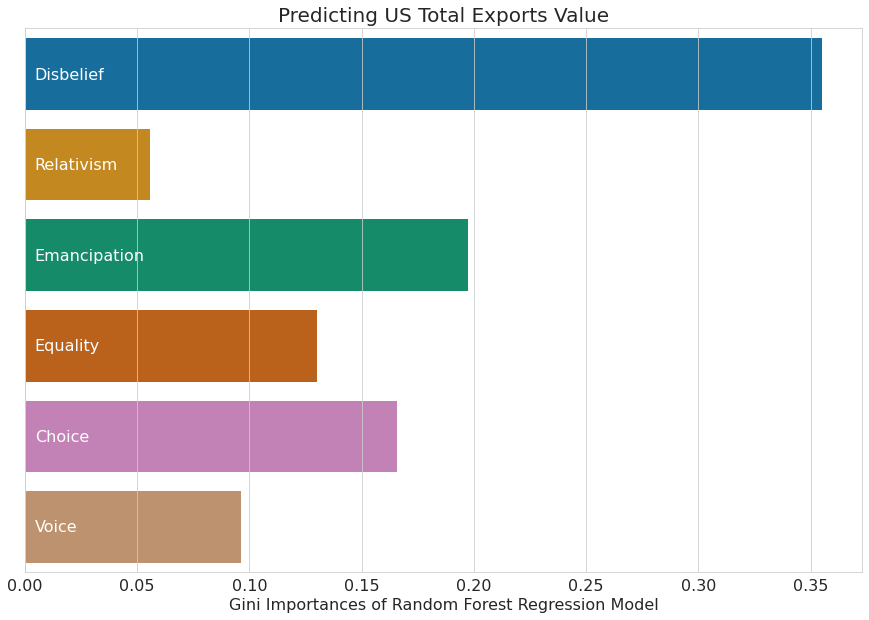

In [182]:
plt.figure(figsize=(15,10))
sns.barplot(x=rfr.feature_importances_, y=['Disbelief', 'Relativism', 'Emancipation', 'Equality', 'Choice', 'Voice'], palette='colorblind',zorder=0.5)
plt.xlabel("Gini Importances of Random Forest Regression Model", size=16)
plt.xticks(size=16)
plt.yticks(ha='left',size=16, x=0.02, c='white')
plt.title('Predicting US Total Exports Value', size=20)
plt.savefig('gini_importances.png')